## Linear Non-Linear Functions



### Preface



Some modules we&rsquo;ll want:



In [1]:
import numpy as np
from numpy.linalg import norm
from scipy.stats import distributions as iid
import pandas as pd
import matplotlib.pyplot as plt

### Factories to generate basis functions



We can use a collection of functions as a *basis* with which to represent
an arbitrary function.



In [2]:
# Factory function for phi_k(x)
phi_factory = lambda c,s=1: lambda x: np.exp(-(1/(2*s))*norm(x-c)**2)  # RBF
# phi_factory = lambda c,s=1: lambda x: (x**c)/s  # Polynomial
# phi_factory = lambda c,s=1: lambda x: 1/(1+np.exp(c-x))  # logistic

# Also chose a domain over which we'll want to evaluate the unknown function
Domain = np.linspace(0,2*np.pi,100).tolist()

Now use  this factory to generate a set of $K$ basis functions for our
representation:



In [38]:
## Or
K=12

# Divide up domain
phis = {k:phi_factory(Domain[x]) for k,x in enumerate(range(1,len(Domain),len(Domain)//K))}

# Gram matrix
#phis = {k:phi_factory(X[k]) for k in range(K)}

phis[0] = lambda x: 1 # Constant function

Plot the basis functions:



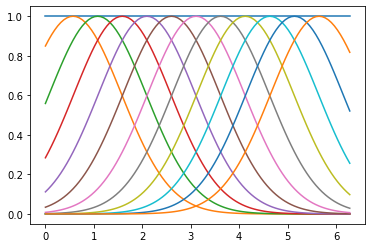

In [39]:
for k in range(K):
    plt.plot(Domain,[phis[k](x) for x in Domain])

### Data generating function



Let $f_0(X) = \mbox{E}(y|X)$ be an arbitrary function.  
After specifying this function we define a data data-generating
function for $(X,y)$ satisfying $y=f(X) + u$ and $\mbox{E}(u|X)$.



In [43]:
f0 = lambda x: x*np.sin(x) # True function; make up your own!

def dgp(N,sigma_u):
    X = iid.uniform(loc=0,scale=2*np.pi).rvs(N).tolist()
    X.sort()

    u = iid.norm(scale=sigma_u)

    y = pd.Series([f0(x) + u.rvs(1)[0] for x in X])

    return X,y

N = 100
X,y = dgp(N,1)

Consider scatterplot:



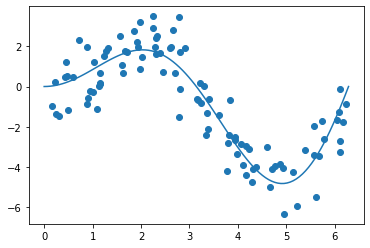

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(X,y)

ax.plot(Domain,[f0(x) for x in Domain])

### Estimation



Now regression.  Suppose we don&rsquo;t know the true function `f0`, and
can only estimate using observed data.



In [45]:
TX = {}
for k in phis.keys():
    TX[k] = [phis[k](x) for x in X]

TX = pd.DataFrame(TX)

try: # If y isn't a DataFrame make it one
    y = pd.DataFrame({'y':y})
except ValueError: # Guess it is!
    pass

alpha = pd.DataFrame(np.linalg.lstsq(TX, y,rcond=None)[0],index=TX.columns)

# Check fit:
e = y.squeeze() - (TX@alpha).squeeze()
e.var()

0.9167485086914293

Note that expected *within* sample error variance is effectively zero!

Now construct $\hat{f}$ and plot predictions:



In [46]:
def fhat(x,alpha):

    try: # Make alpha 1-d for calculations here
        alpha = alpha.squeeze()
    except AttributeError: # Maybe a list?
        pass
    
    yhat = 0
    for k,phik in phis.items():
        yhat += alpha[k]*phik(x)

    return yhat

Domain = np.linspace(0,2*np.pi,100).tolist()

Plot me!



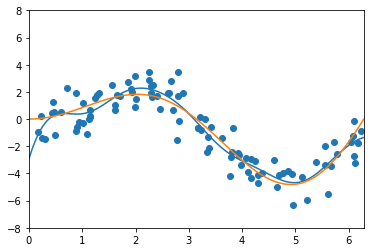

In [48]:
fig, ax = plt.subplots()
ax.scatter(X,y)
_ = ax.plot(Domain,[fhat(x,alpha) for x in Domain])
ax.axis((0,2*np.pi,-8,8))
ax.plot(Domain,[f0(x) for x in Domain])

### Evaluating Fit



We&rsquo;d like a measure of how well we&rsquo;ve done in estimating the
conditional expectation $f$.  First, compute the mean squared error
(MSE).  Note that when we don&rsquo;t know the true function `f_0` that this
is isn&rsquo;t feasible to compute.  Here we compute a sum of squared
prediction errors as a crude way of computing the integral $$ \int
(f_0(x) - \hat{f}(x))^2dx.  $$ This Riemann integral is appropriate
here because $x$ is uniformly distributed&#x2013;in general we want to
integrate with respect to $dF$.



In [49]:
dx = Domain[1]-Domain[0]
MSE = np.sum([((f0(x) - fhat(x,alpha))**2)*dx for x in Domain])

MSE

1.813688485781162

Note that the disturbances $u$ don&rsquo;t
enter here&#x2014;this is the mean squared *approximation* error, not the
mean squared error of predictions of actual realizations of the data
$(y,X)$.  If we wanted the latter we&rsquo;d compute
$$
   \mbox{E}((y-\hat{f}(X))^2) =  \mbox{E}((y-f(X)-\epsilon)^2) =
\mbox{E}u^2 + \mbox{MSE}.
$$



#### Leave-one-out estimator



We next estimate $f$ using the &ldquo;leave-one-out&rdquo; approach.



In [50]:
Yminus = []
Alpha = {}
for j in range(N):
    alphaminus = pd.DataFrame(np.linalg.lstsq(TX[TX.index!=j],
                                         y[TX.index!=j],rcond=None)[0],index=TX.columns)
    yminus = lambda x: fhat(x,alphaminus)
    Alpha[j]=alphaminus.squeeze()
    Yminus.append(yminus)

Alpha = pd.DataFrame(Alpha)

yhat = lambda x: np.array([yminus(x) for yminus in Yminus]).mean()

In [25]:
Alpha

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-130.562326,-79.799975,-132.080777,-84.489315,-53.102631,-118.566511,-56.435780,-103.247869,-47.654614,-86.915509,-123.471902,-82.177499,-79.682211,26.953036,-68.714185,-41.819373,174.415670,-64.933417,-141.533274,-63.136342
1,330.420898,237.214668,363.098200,288.135750,162.657444,349.791133,165.620193,294.751616,149.064233,269.675996,335.036136,242.266303,230.318618,-7.598411,220.726717,153.234796,-306.379275,214.560455,367.893993,207.644575
2,-629.836638,-483.643719,-706.291272,-611.642108,-341.004130,-712.149607,-333.778228,-591.448761,-305.031110,-560.219953,-656.002188,-490.529952,-460.592877,-41.665087,-465.376653,-335.754001,433.579236,-459.125258,-699.086889,-442.460123
3,1044.434559,796.340958,1152.672815,992.767718,571.691728,1173.005457,548.964146,976.618013,494.062764,922.967381,1082.891236,805.284847,752.889277,57.561797,769.693537,550.296923,-694.618101,764.515838,1139.648813,734.352891
4,-1224.485636,-935.252415,-1339.316215,-1155.720539,-683.804428,-1374.494450,-647.344044,-1149.211224,-573.220760,-1084.144772,-1272.816906,-942.804208,-876.706175,-61.090641,-912.450923,-647.178953,750.840366,-917.502268,-1311.217757,-877.245504
5,1398.337468,1036.029125,1500.744461,1244.084340,760.669165,1515.517750,726.823295,1282.193730,633.453386,1185.733109,1437.186633,1045.193640,975.080928,6.187464,1003.021573,694.785273,-950.237043,1017.872848,1471.095932,970.778869
6,-1275.635878,-926.293501,-1351.984438,-1088.465348,-682.461900,-1346.985922,-658.599321,-1150.498220,-570.210098,-1047.317850,-1301.215231,-935.546506,-876.837709,32.088796,-891.153947,-607.051435,915.905687,-918.415541,-1318.850330,-874.132041
7,1116.704808,778.747986,1165.397905,887.989067,566.414816,1130.444732,558.908329,974.671111,481.533066,867.602990,1118.606682,789.823718,747.596423,-80.265981,732.415016,486.963362,-949.657304,760.177580,1147.600977,725.391574
8,-698.759537,-477.108148,-722.239532,-532.332995,-345.681599,-688.394974,-346.532916,-597.958874,-299.153298,-525.699192,-691.389692,-485.260025,-462.949509,60.237094,-441.467136,-292.061416,643.614228,-461.263136,-715.286092,-442.974334
9,360.715392,235.154390,368.717537,255.647294,165.433688,341.849176,170.087232,298.028365,145.954229,256.990096,349.586701,240.452758,231.400844,-48.169156,211.001298,135.861968,-396.015440,214.365579,376.613332,208.438521


Take a look at $f$ and the leave-one-out estimator:



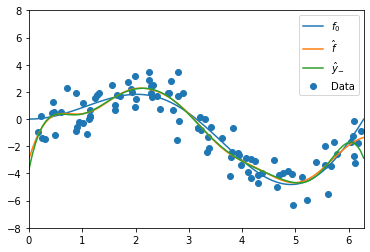

In [51]:
fig, ax = plt.subplots()

ax.scatter(X,y,label='Data')

ax.plot(Domain,[f0(x) for x in Domain],label='$f_0$')

ax.plot(Domain,[fhat(x,alpha) for x in Domain],label='$\hat{f}$')

ax.plot(Domain,[yhat(x) for x in Domain],label='$\hat{y}_{-}$')
ax.axis((0,2*np.pi,-8,8))
ax.legend()

(0.0, 6.283185307179586, -8.0, 8.0)

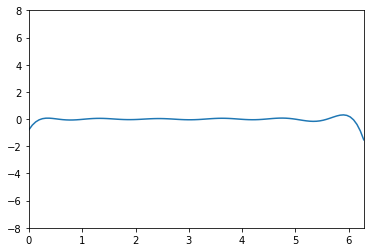

In [52]:
fig, ax = plt.subplots()

ax.plot(Domain,[yhat(x) - fhat(x,alpha) for x in Domain],label='$\hat{y}(x) - \hat{f}(x)$')
ax.axis((0,2*np.pi,-8,8))

#### Cross-validation error



The cross-validation criterion relies on the leave-one-out estimator
      $$
          \mbox{CV} = \frac{1}{N}\sum_{j=1}^N e_{-j}^2.
      $$



In [53]:
CV = 0
for j in range(N):
     CV += (y.squeeze()[j] - Yminus[j](X[j]))**2/N
        
CV

0.9245821535480439